In [2]:
import sys
sys.path.append("/home/ashtik/ub_cse_cda_500/cda_500_nyc_taxi")


import sys
sys.path.append("/home/ashtik/ub_cse_cda_500/cda_500_nyc_taxi/src")


In [ ]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


from src.pipeline_utils import (
    average_rides_last_4_weeks,
    TemporalFeatureEngineer,
    FFTFeatureEngineer
)

from datetime import datetime

# === Your custom imports ===
from src.data_utils import split_time_series_data
from src.config import TRANSFORMED_DATA_DIR

# ---- 1) Load Data ----
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df["pickup_hour"].info()

X_train, y_train, X_test, y_test = split_time_series_data(
    df, cutoff_date=datetime(2023, 9, 1, 0, 0, 0), target_column="target"
)
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)


# ---- Create two pipelines: no FFT vs. FFT ----
# Pipeline A: No FFT (baseline)
baseline_pipeline = make_pipeline(
    add_feature_average_rides_last_4_weeks,
    add_temporal_features,
    lgb.LGBMRegressor()  # default LGBM
)

# Pipeline B: With FFT
fft_pipeline = make_pipeline(
    add_feature_average_rides_last_4_weeks,
    add_temporal_features,
    FFTFeatureEngineer(window_size=24, top_k=5, drop_original=False),
    lgb.LGBMRegressor()
)

# 3) Set MLflow experiment
mlflow.set_experiment("FFT_Comparison_Experiment")

# ------------------------------------------------------------------------
# HELPER FUNCTION: 2-step tuning for any pipeline
# ------------------------------------------------------------------------
def two_step_tuning(pipeline, run_name_prefix="No FFT"):
    # Step 1: Learning rate only
    step1_param_grid = {
        "lgbmregressor__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3]
    }

    with mlflow.start_run(run_name=f"{run_name_prefix} - Step 1"):
        gridsearch = GridSearchCV(
            estimator=pipeline,
            param_grid=step1_param_grid,
            scoring="neg_mean_absolute_error",
            cv=3,
            verbose=2
        )
        gridsearch.fit(X_train, y_train)
        best_lr = gridsearch.best_params_["lgbmregressor__learning_rate"]
        cv_mae_step1 = -gridsearch.best_score_

        mlflow.log_param("best_learning_rate", best_lr)
        mlflow.log_metric("cv_mae_step1", cv_mae_step1)
        
        # Evaluate on test
        step1_best_model = gridsearch.best_estimator_
        y_pred_step1 = step1_best_model.predict(X_test)
        test_mae_step1 = mean_absolute_error(y_test, y_pred_step1)
        mlflow.log_metric("test_mae_step1", test_mae_step1)

        print(f"{run_name_prefix} - Step 1 - Best LR: {best_lr}")
        print(f"{run_name_prefix} - Step 1 - CV MAE: {cv_mae_step1:.3f}")
        print(f"{run_name_prefix} - Step 1 - Test MAE: {test_mae_step1:.3f}")

    # Step 2: Fix best LR, tune other hyperparams
    # We clone the pipeline with the best LR
    from sklearn.base import clone
    tuned_pipeline = clone(pipeline)
    tuned_pipeline[-1].set_params(learning_rate=best_lr) 
    # the LGBMRegressor is the last step in the pipeline

    step2_param_dist = {
        "lgbmregressor__num_leaves": [31, 50, 70, 100, 256],
        "lgbmregressor__min_child_samples": [5, 10, 20, 40],
        "lgbmregressor__subsample": [0.7, 0.8, 1.0],
        "lgbmregressor__colsample_bytree": [0.7, 0.8, 1.0]
    }

    with mlflow.start_run(run_name=f"{run_name_prefix} - Step 2"):
        random_search = RandomizedSearchCV(
            estimator=tuned_pipeline,
            param_distributions=step2_param_dist,
            n_iter=10,
            scoring="neg_mean_absolute_error",
            cv=3,
            verbose=2,
            random_state=42
        )
        random_search.fit(X_train, y_train)

        best_params = random_search.best_params_
        cv_mae_step2 = -random_search.best_score_
        mlflow.log_params(best_params)
        mlflow.log_metric("cv_mae_step2", cv_mae_step2)

        final_best_model = random_search.best_estimator_
        y_pred_step2 = final_best_model.predict(X_test)
        test_mae_step2 = mean_absolute_error(y_test, y_pred_step2)
        mlflow.log_metric("test_mae_step2", test_mae_step2)

        print(f"{run_name_prefix} - Best Params Step 2: {best_params}")
        print(f"{run_name_prefix} - CV MAE Step 2: {cv_mae_step2:.3f}")
        print(f"{run_name_prefix} - Test MAE Step 2: {test_mae_step2:.3f}")

    return final_best_model, test_mae_step2

# ------------------------------------------------------------------------
# 4) Baseline Pipeline (No FFT)
# ------------------------------------------------------------------------
baseline_model, baseline_final_mae = two_step_tuning(
    pipeline=baseline_pipeline, run_name_prefix="No FFT"
)

# ------------------------------------------------------------------------
# 5) FFT Pipeline
# ------------------------------------------------------------------------
fft_model, fft_final_mae = two_step_tuning(
    pipeline=fft_pipeline, run_name_prefix="With FFT"
)

# ------------------------------------------------------------------------
# 6) Compare Results
# ------------------------------------------------------------------------
print("\n================== FINAL COMPARISON ==================")
print(f"No FFT Final MAE:  {baseline_final_mae:.3f}")
print(f"FFT Final MAE:     {fft_final_mae:.3f}")

if fft_final_mae < baseline_final_mae:
    print("FFT features improved the performance!")
else:
    print("FFT features did not help, or at least not in this config.")


<class 'pandas.core.series.Series'>
RangeIndex: 87620 entries, 0 to 87619
Series name: pickup_hour
Non-Null Count  Dtype         
--------------  -----         
87620 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 684.7 KB
Train set size: (55900, 674)
Test set size: (31720, 674)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156723
[LightGBM] [Info] Number of data points in the train set: 37266, number of used features: 674
[LightGBM] [Info] Start training from score 13.482799
[CV] END ..................lgbmregressor__learning_rate=0.01; total time=   6.4s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153420
[LightGBM] [Info]

In [4]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [5]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-03 00:03:23,481 INFO: Initializing external client
2025-03-03 00:03:23,482 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-03 00:03:24,342 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214632


In [6]:
# Create a feature view if it doesn't already exist
# try:
#     feature_store.create_feature_view(
#         name=config.FEATURE_VIEW_NAME,
#         version=config.FEATURE_VIEW_VERSION,
#         query=feature_group.select_all(),
#     )
#     print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
# except Exception as e:
#     print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [7]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.73s) 


In [8]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [9]:
ts_data.head()
ts_data_copy = ts_data.copy()
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [10]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [11]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

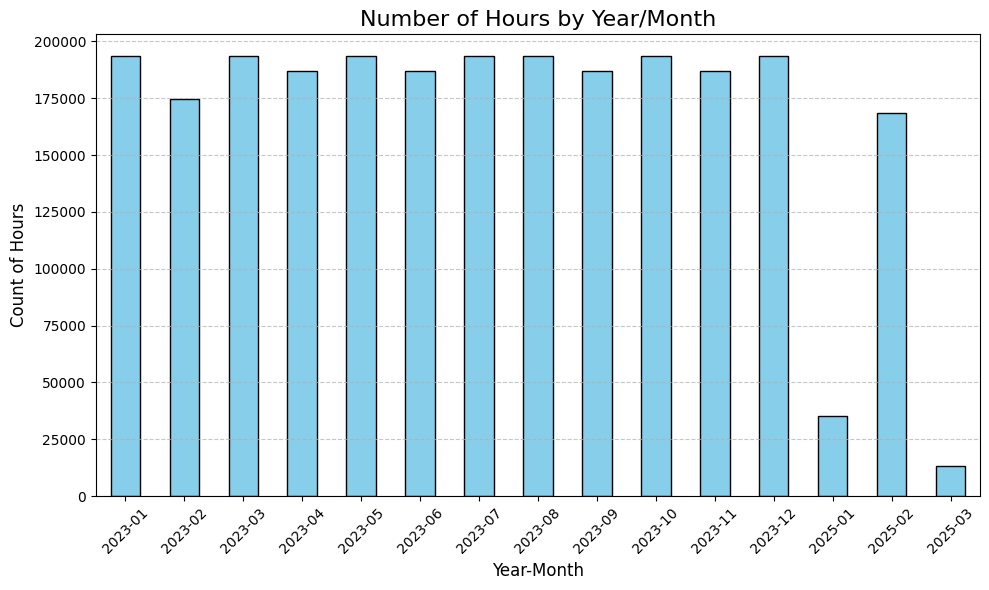

In [12]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [13]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


In [14]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [15]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [16]:
filtered_data.shape

(2277600, 3)

In [17]:
ts_data = filtered_data

In [18]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [19]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91520, 675)

In [20]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# For example, assume 'features' is a pandas DataFrame 
# used as input and 'targets' is a pandas Series or DataFrame for outputs.

input_schema = Schema(features)
output_schema = Schema(targets)

model_schema = ModelSchema(
    input_schema=input_schema,
    output_schema=output_schema
)


In [21]:
import joblib  # or pickle
# Suppose your final best model is called 'best_model'
joblib.dump(fft_model, "/home/ashtik/ub_cse_cda_500/cda_500_nyc_taxi/models/lgb_model.pkl")


import joblib  # or pickle
# Suppose your final best model is called 'best_model'
joblib.dump(fft_model, "/home/ashtik/ub_cse_cda_500/cda_500_nyc_taxi/src/lgb_model.pkl")

['/home/ashtik/ub_cse_cda_500/cda_500_nyc_taxi/src/lgb_model.pkl']

In [23]:
fft_final_mae

3.215850550588589

In [25]:
# Retrieve your project's Model Registry
model_registry = project.get_model_registry()

# Create the model entry in the registry
model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": fft_final_mae},
    description="LightGBM regressor tuned",
    input_example=features.sample(),   # an example row of inputs
    model_schema=model_schema,
    # include_files=["src/", "requirements.txt"]  # optional if you have source code to bundle
)

# Save the model artifacts (pickle, etc.) to Hopsworks
# Typically you provide a local path to the model file
model.save("/home/ashtik/ub_cse_cda_500/cda_500_nyc_taxi/models/lgb_model.pkl")

# lgb_model.pkl

print("Model successfully saved to Hopsworks Model Registry!")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/2299859 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3166 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48616 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214632/models/taxi_demand_predictor_next_hour/4
Model successfully saved to Hopsworks Model Registry!


In [1]:
import sys
sys.path.append("/home/ashtik/ub_cse_cda_500/cda_500_nyc_taxi")


import sys
sys.path.append("/home/ashtik/ub_cse_cda_500/cda_500_nyc_taxi/src")


In [2]:
from src.pipeline_utils import (
    TemporalFeatureEngineer,
    average_rides_last_4_weeks,  # Make sure this is correctly imported
)


In [3]:
from src.inference import load_model_from_registry

model = load_model_from_registry()
from sklearn.metrics import mean_absolute_error


# Suppose you have a function get_model_predictions that 
# wraps the pipeline's predict method:
from src.inference import get_model_predictions

predictions_df = get_model_predictions(model, features)  
# 'predictions_df' might be a DataFrame with a "predicted_demand" column

test_mae_loaded = mean_absolute_error(targets, predictions_df["predicted_demand"])
print(f"MAE of model loaded from Hopsworks: {test_mae_loaded:.4f}")

2025-03-03 00:12:22,493 INFO: Initializing external client
2025-03-03 00:12:22,494 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-03 00:12:23,303 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214632
<function average_rides_last_4_weeks at 0x7f13a56f45e0>


AttributeError: Can't get attribute 'FFTFeatureEngineer' on <module '__main__'>